In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-23 17:22:10 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-23 17:22:10 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-23 17:22:10 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-23 17:22:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-23 17:22:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-23 17:22:18 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-23 17:22:18 wandb.docker.auth DEBUG    No config file found


In [4]:
# from nnsight import LanguageModel

# lm = LanguageModel(
#     model_key,
#     device_map="auto",
#     dispatch=True,
# )

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-23 17:22:34 src.models WARNING  google/gemma-2-27b-it not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-23 17:22:34 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-23 17:22:34 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/config.json HTTP/1.1" 200 0
2025-09-23 17:22:35 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-23 17:22:35 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/google/gemma-2-27b-it/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

2025-09-23 17:23:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-23 17:23:00 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-23 17:23:00 src.models INFO     loaded model <google/gemma-2-27b-it> | size: 51931.626 MB | dtype: torch.bfloat16 | device: cuda:0


In [16]:
from src.selection.data import SelectOneTask, CountingTask, get_counterfactual_samples_interface

#################################################################################
# TASK_CLS = CountingTask
TASK_CLS = SelectOneTask
prompt_template_idx = 2
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

test_sample = select_task.get_random_sample(
    mt=mt,
    prompt_template_idx=prompt_template_idx,
    n_distractors=N_DISTRACTORS,
    option_style=OPTION_STYLE,
)
print(test_sample.prompt(), ">>", mt.tokenizer.decode(test_sample.ans_token_id))

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)

Which object from the following list is a furniture?
Options: Ottoman, Shorts, Ash, Tractor, Juicer, Razor.
Answer: >>  Ottoman


In [17]:
from src.selection.data import get_counterfactual_samples_within_task

counterfact_sampler = get_counterfactual_samples_interface[select_task.task_name]

kwargs = {}
if TASK_CLS == CountingTask:
    kwargs["clean_n_options"] = N_DISTRACTORS + 1
    kwargs["patch_n_options"] = N_DISTRACTORS + 1
else:
    kwargs["clean_n_distractors"] = N_DISTRACTORS
    kwargs["patch_n_distractors"] = N_DISTRACTORS
    kwargs["clean_prompt_template_idx"] = prompt_template_idx
    kwargs["patch_prompt_template_idx"] = prompt_template_idx

patch_sample, clean_sample = counterfact_sampler(
    mt=mt,
    task=select_task,
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_category="fruit",
    clean_category="vehicle",
    **kwargs,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print("=" * 80)

print(patch_sample.prompt(), ">>", mt.tokenizer.decode(patch_sample.ans_token_id))
print(clean_sample.prompt(), ">>", mt.tokenizer.decode(clean_sample.ans_token_id))

2025-09-23 17:32:48 src.selection.data INFO     clean_obj_idx=4 | ['Church', 'Blueberry', 'Toaster', 'Racket', 'Scooter', 'Ring']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-23 17:32:48 src.selection.data INFO     Which object from the following list is a fruit?
Options: Pineapple, Shorts, Bus, Printer, Yoga mat, Bangle.
Answer:
2025-09-23 17:32:48 src.selection.data INFO     Apple | fruit -> Pineapple | pred=['" Pineapple"[134692] (p=0.980, logit=22.750)', '" **"[5231] (p=0.016, logit=18.625)', '"\n\n"[109] (p=0.001, logit=15.500)', '"  "[139] (p=0.000, logit=15.000)', '"\n"[108] (p=0.000, logit=14.375)']
2025-09-23 17:32:48 src.selection.data INFO     Which object from the following list is a vehicle?
Options: Church, Blueberry, Toaster, Racket, Scooter, Ring.
Answer:
2025-09-23 17:32:48 src.selection.data INFO     Airplane | vehicle -> Scooter | pred=['" Scooter"[141981] (p=0.980, logit=22.875)', '" **"[5231] (p=0.018, logit=18.875)', '"  "[139] (p=0.000, logit=14.

In [18]:
from src.tokens import prepare_input

clean_tokenized = prepare_input(tokenizer=mt, prompts=clean_sample.prompt())
print(mt.tokenizer.decode(clean_tokenized.input_ids[0], skip_special_tokens=False))

<bos>Which object from the following list is a vehicle?
Options: Church, Blueberry, Toaster, Racket, Scooter, Ring.
Answer:


In [19]:
from src.tokens import prepare_input
from src.selection.utils import get_first_token_id
from src.functional import interpret_logits, PatchSpec
from itertools import product
from src.utils.typing import TokenizerOutput, ArrayLike
from typing import Optional, Union
from src.functional import get_module_nnsight, untuple, get_hs, predict_next_token
from src.selection.data import SelectionSample
import random
from src.selection.functional import find_quesmark_pos
from src.selection.data import get_options_for_answer

def layer_wise_patching(
    mt: ModelandTokenizer,
    patch_sample: SelectionSample,
    clean_sample: SelectionSample,
    map_indices: list[int] = {-2: -2, -1: -1},
    consider_ques_pos: bool = True,
):
    clean_tokenized = prepare_input(
        prompts=clean_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    patch_tokenized = prepare_input(
        prompts=patch_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    clean_offset_mapping = clean_tokenized.pop("offset_mapping")[0]
    patch_offset_mapping = patch_tokenized.pop("offset_mapping")[0]
    if consider_ques_pos:
        clean_ques_pos = find_quesmark_pos(
            prompt=clean_sample.prompt(),
            tokenizer=mt.tokenizer,
            tokenized=clean_tokenized,
            offset_mapping=clean_offset_mapping,
        )
        patch_ques_pos = find_quesmark_pos(
            prompt=patch_sample.prompt(),
            tokenizer=mt.tokenizer,
            tokenized=patch_tokenized,
            offset_mapping=patch_offset_mapping,
        )
        map_indices[patch_ques_pos] = clean_ques_pos

    random_idx = random.choice(
        list(
            set(list(range(len(clean_sample.options))))
            - {
                patch_sample.obj_idx,
                clean_sample.obj_idx,
                clean_sample.metadata["track_type_obj_idx"],
            }
        )
    )

    track_tokens = {
        "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "patch_position": get_first_token_id(
            clean_sample.options[patch_sample.obj_idx], mt.tokenizer, prefix=" "
        ),
        "random_distractor": get_first_token_id(
            clean_sample.options[random_idx], mt.tokenizer, prefix=" "
        ),
    }

    ret = {"track_tokens": track_tokens}

    logit_location = (mt.lm_head_name, -1)
    cache_h_from_locations = list(product(mt.layer_names, list(map_indices.keys())))
    # patch_locations = []
    print(cache_h_from_locations)

    patch_hs = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=cache_h_from_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = patch_hs[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")
    ret["patch_pred"] = patch_pred
    ret["patch_track"] = patch_track

    clean_hs = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=[logit_location],
        return_dict=True,
    )
    clean_logits = clean_hs[logit_location]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")
    ret["clean_pred"] = clean_pred
    ret["clean_track"] = clean_track

    interestested_tokens = list(track_tokens.values())
    option_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(clean_sample)
    ]
    interestested_tokens = list(set(interestested_tokens) | set(option_tokens))
    layer_wise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for patch_tok_idx in map_indices.keys():
            patch_spec.append(
                PatchSpec(
                    location=(layer, map_indices[patch_tok_idx]),
                    patch=patch_hs[(layer, patch_tok_idx)],
                )
            )

        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]

        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=interestested_tokens,
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")
        layer_wise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    ret["layer_wise_patching_results"] = layer_wise_patching_results
    return ret


patching_result = layer_wise_patching(
    mt=mt,
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    map_indices={-2: -2, -1: -1},
    consider_ques_pos=True,
)

[('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.0', 10), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.1', 10), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.2', 10), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.3', 10), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.4', 10), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.5', 10), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.6', 10), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.7', 10), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.8', 10), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.9', 10), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.10', 10), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.11', 10), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.12', 10), ('model.layers.13', -2), ('model.layers.13', -1), ('mo

In [20]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 64

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

len(validation_set)

sample 1 / 64
2025-09-23 17:33:02 src.selection.data INFO     clean_obj_idx=4 | ['Horse', 'Lily', 'Kiwi', 'Skis', 'Slow cooker', 'Asparagus']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-23 17:33:02 src.selection.data INFO     Which object from the following list is a sport equipment?
Options: Palm, Juicer, Surfboard, Guitar, Helicopter, Desk.
Answer:
2025-09-23 17:33:02 src.selection.data INFO     Bat | sport equipment -> Surfboard | pred=['" Surf"[60735] (p=0.988, logit=23.125)', '" **"[5231] (p=0.011, logit=18.625)', '"\n\n"[109] (p=0.000, logit=15.000)', '"  "[139] (p=0.000, logit=14.375)', '"\n"[108] (p=0.000, logit=13.938)']
2025-09-23 17:33:02 src.selection.data INFO     Which object from the following list is a kitchen appliance?
Options: Horse, Lily, Kiwi, Skis, Slow cooker, Asparagus.
Answer:
2025-09-23 17:33:02 src.selection.data INFO     Coffee maker | kitchen appliance -> Slow cooker | pred=['" Slow"[33936] (p=0.949, logit=21.250)', '" **"[5231] (p=0.047, 

64

In [23]:
from tqdm.auto import tqdm

results = []
for clean, patch in tqdm(validation_set):
    result = layer_wise_patching(
        mt=mt,
        patch_sample=patch,
        clean_sample=clean,
        map_indices={-2: -2, -1: -1},
        consider_ques_pos=True,
    )
    results.append(result)

  0%|          | 0/64 [00:00<?, ?it/s]

[('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.0', 11), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.1', 11), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.2', 11), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.3', 11), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.4', 11), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.5', 11), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.6', 11), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.7', 11), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.8', 11), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.9', 11), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.10', 11), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.11', 11), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.12', 11), ('model.layers.13', -2), ('model.layers.13', -1), ('mo

In [24]:
# results = [patching_result]

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
causality = []
for result in results:
    clean_track = result["clean_track"]
    patch_track = result["patch_track"]

    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layer_wise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)
    
    predicate_target = result["track_tokens"]["predicate_target"] 
    layer_wise_causality = []
    for layer_idx in range(mt.n_layer):
        int_track = result["layer_wise_patching_results"][mt.layer_names[layer_idx]]["int_track"]
        is_causal = float(list(int_track.keys())[0] == predicate_target)
        layer_wise_causality.append(is_causal)
    causality.append(layer_wise_causality)

2025-09-23 17:42:16 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-09-23 17:42:16 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-09-23 17:42:16 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


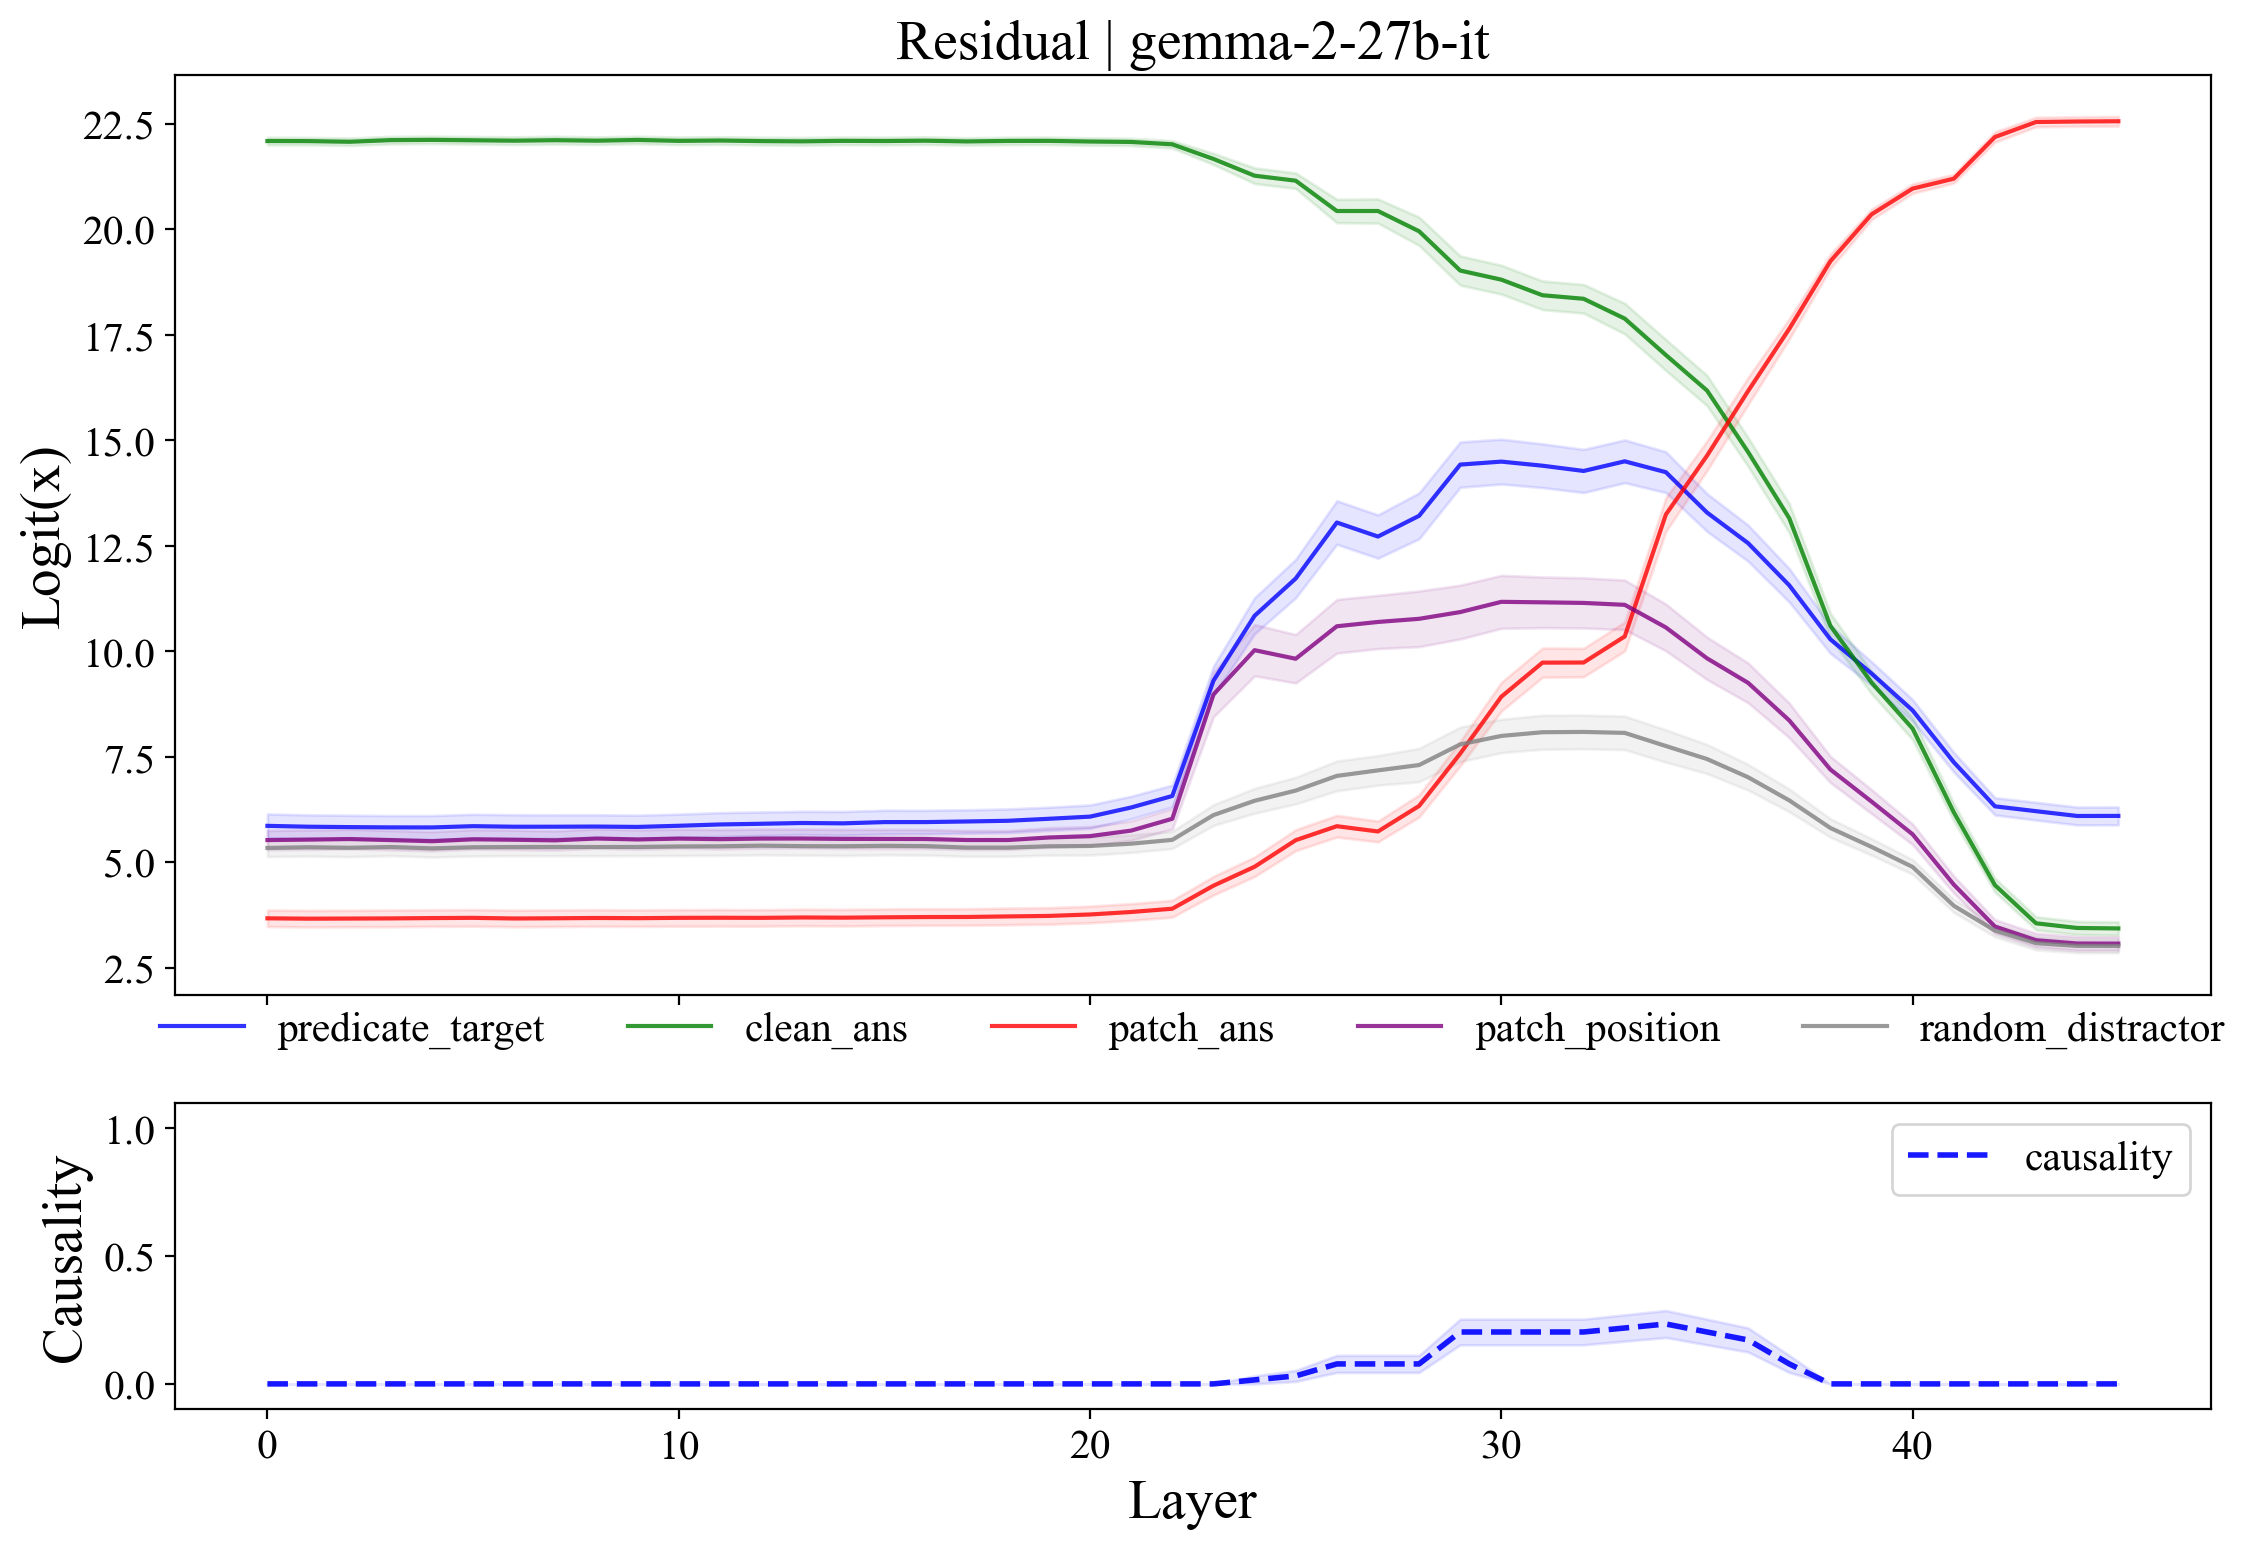

In [25]:
import numpy as np

# Create a figure with two vertically stacked subplots (shared x-axis)
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)
colors = {
    "predicate_target": "blue",
    "clean_ans": "green",
    "patch_ans": "red",
    "patch_position": "purple",
    "random_distractor": "gray",
}

# Plot logits on the first panel
lines = []
for token_type, layerwise_scores_list in scores.items():
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )
    line, = ax1.plot(mean_scores, label=f"{token_type}", alpha=0.8, color=colors[token_type])
    ax1.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors[token_type],
    )
    lines.append(line)

ax1.set_ylabel("Logit(x)")
ax1.set_title(f"Residual | {mt.name.split('/')[-1]}")

# Place the legend horizontally on top of the first panel
ax1.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=len(scores),
    frameon=False,
    fontsize="medium"
)

# Plot causality on the second panel
mean_causality = np.mean(causality, axis=0)
sterr_causality = np.std(causality, axis=0) / np.sqrt(len(causality))
ax2.plot(
    mean_causality,
    label="causality",
    color=colors["predicate_target"],
    linestyle="--",
    alpha=0.9,
    linewidth=2,
)
ax2.fill_between(
    range(len(mean_causality)),
    mean_causality - sterr_causality,
    mean_causality + sterr_causality,
    color=colors["predicate_target"],
    alpha=0.1,
)
ax2.set_xlabel("Layer")
ax2.set_ylabel("Causality")
ax2.set_ylim(-0.1, 1.1)
ax2.legend()

plt.tight_layout()
save_dir = os.path.join("figures", model_key.split("/")[-1], "residual")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"template_{prompt_template_idx}.pdf"), bbox_inches="tight")

## Patching to check if there is an answer flag

In [26]:
from src.selection.utils import verify_correct_option
import random


def get_counterfactual_sample_with_answer_flag(
    mt: ModelandTokenizer,
    select_task: SelectOneTask,
    clean_category: str = "fruit",
    patch_category: str = "vehicle",
    flag_category: str = "animal",
    n_other_distractors: int = 2,
    prompt_template_idx=2,
    option_style: str = OPTION_STYLE,
    filter_by_lm_prediction: bool = True,
    retry_count: int = 0,
):
    distractor_categories = random.sample(
        list(
            set(select_task.category_wise_examples.keys())
            - {clean_category, patch_category, flag_category}
        ),
        k=n_other_distractors,
    )

    obj_to_category_map = {}
    clean_obj = random.choice(select_task.category_wise_examples[clean_category])
    patch_obj = random.choice(select_task.category_wise_examples[patch_category])
    flag_obj = random.choice(select_task.category_wise_examples[flag_category])

    obj_to_category_map[clean_obj] = clean_category
    obj_to_category_map[patch_obj] = patch_category
    obj_to_category_map[flag_obj] = flag_category

    logger.info(f"{clean_obj=}, {patch_obj=}, {flag_obj=}")

    options = [clean_obj, patch_obj, flag_obj]

    for category in distractor_categories:
        obj = random.choice(select_task.category_wise_examples[category])
        obj_to_category_map[obj] = category
        options.append(obj)

    random.shuffle(options)

    random_obj = random.choice(list(set(options) - {clean_obj, patch_obj, flag_obj}))
    logger.info(f"{random_obj=}")
    logger.info(f"{options=}")

    clean_sample = SelectionSample(
        obj=clean_obj,
        obj_idx=options.index(clean_obj),
        options=options,
        answer=clean_obj,
        category=clean_category,
        ans_token_id=get_first_token_id(
            name=clean_obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        prompt_template=select_task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )

    patch_sample = SelectionSample(
        obj=patch_obj,
        obj_idx=options.index(patch_obj),
        options=options,
        answer=patch_obj,
        category=patch_category,
        ans_token_id=get_first_token_id(
            name=patch_obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        prompt_template=select_task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )

    # get a sample where the flag obj is the answer
    flag_sample = select_task.get_random_sample(
        mt=mt,
        category=flag_category,
        prompt_template_idx=prompt_template_idx,
        option_style=option_style,
        n_distractors=len(options) - 1,
    )
    flag_sample.options[flag_sample.options.index(flag_sample.obj)] = flag_obj
    flag_sample.obj = flag_obj
    flag_sample.ans_token_id = get_first_token_id(
        name=flag_obj, tokenizer=mt.tokenizer, prefix=" "
    )

    distractor_samples = {}
    # get samples where the distractor obj is NOT the answer
    for distractor_obj, distractor_category in obj_to_category_map.items():
        if distractor_obj == flag_obj:
            # No need
            continue
        other_category = random.choice(
            list(
                set(select_task.category_wise_examples.keys())
                - {clean_category, patch_category, flag_category, distractor_category}
            )
        )
        obj_idx = random.choice(range(len(options)))
        distractor_sample = select_task.get_random_sample(
            mt=mt,
            category=other_category,
            obj_idx=obj_idx,
            prompt_template_idx=prompt_template_idx,
            option_style=option_style,
            n_distractors=len(options) - 1,
            exclude_distractor_categories=[
                clean_category,
                patch_category,
                flag_category,
                distractor_category,
            ],
            insert_distractor=[
                (
                    distractor_obj,
                    random.choice(list(set(range(len(options))) - {obj_idx})),
                )
            ],
        )
        distractor_samples[distractor_obj] = distractor_sample

    if filter_by_lm_prediction:
        for sample in [clean_sample, patch_sample, flag_sample]:
            is_correct, pred, track_objs = verify_correct_option(
                mt=mt,
                input=sample.prompt(),
                target=sample.ans_token_id,
                options=sample.options,
            )

            if not is_correct:
                logger.error(
                    f"""Sample = {sample}
Top prediction {track_objs[list(track_objs.keys())[0]]} does not match the object {sample.obj}[{sample.ans_token_id}, "{mt.tokenizer.decode(sample.ans_token_id)}"].
Retry count: {retry_count + 1}. Retrying ...
"""
                )
                return get_counterfactual_sample_with_answer_flag(
                    mt=mt,
                    select_task=select_task,
                    clean_category=clean_category,
                    patch_category=patch_category,
                    flag_category=flag_category,
                    prompt_template_idx=prompt_template_idx,
                    retry_count=retry_count + 1,
                )

        # for the distractors just make sure that the distractor obj is not the answer
        for distractor_obj, distractor_sample in distractor_samples.items():
            pred, track_objs = predict_next_token(
                mt=mt,
                inputs=distractor_sample.prompt(),
                token_of_interest=[
                    get_first_token_id(opt, mt.tokenizer, prefix=" ")
                    for opt in distractor_sample.options
                ],
            )
            track_objs = track_objs[0]
            if list(track_objs.keys())[0] == get_first_token_id(
                distractor_obj, mt.tokenizer, prefix=" "
            ):
                logger.error(
                    f"""Sample = {distractor_sample}
Top prediction {track_objs[list(track_objs.keys())[0]]} matches the distractor object {distractor_obj}[{distractor_sample.ans_token_id}, "{mt.tokenizer.decode(distractor_sample.ans_token_id)}"].
Retry count: {retry_count + 1}. Retrying ...
"""
                )
                return get_counterfactual_sample_with_answer_flag(
                    mt=mt,
                    select_task=select_task,
                    clean_category=clean_category,
                    patch_category=patch_category,
                    flag_category=flag_category,
                    prompt_template_idx=prompt_template_idx,
                    retry_count=retry_count + 1,
                )

    return clean_sample, patch_sample, flag_sample, distractor_samples


clean_sample, patch_sample, flag_sample, distractor_samples = (
    get_counterfactual_sample_with_answer_flag(
        mt=mt,
        select_task=select_task,
        clean_category="fruit",
        patch_category="vehicle",
        flag_category="animal",
        n_other_distractors=2,
        prompt_template_idx=2,
        option_style=OPTION_STYLE,
        retry_count=0,
        filter_by_lm_prediction=True,
    )
)

print("clean")
print(clean_sample.prompt(), ">>", mt.tokenizer.decode(clean_sample.ans_token_id))

print("patch")
print(patch_sample.prompt(), ">>", mt.tokenizer.decode(patch_sample.ans_token_id))

print("flag")
print(flag_sample.prompt(), ">>", mt.tokenizer.decode(flag_sample.ans_token_id))

print("------------------------------")
for distractor_obj, distractor_sample in distractor_samples.items():
    print("distractor:", distractor_obj)
    print(
        distractor_sample.prompt(),
        ">>",
        mt.tokenizer.decode(distractor_sample.ans_token_id),
    )

2025-09-23 17:42:44 __main__ INFO     clean_obj='Banana', patch_obj='Motorcycle', flag_obj='Tiger'
2025-09-23 17:42:44 __main__ INFO     random_obj='Redwood'
2025-09-23 17:42:44 __main__ INFO     options=['Banana', 'Redwood', 'Tiger', 'Laptop', 'Motorcycle']


clean
Which object from the following list is a fruit?
Options: Banana, Redwood, Tiger, Laptop, Motorcycle.
Answer: >>  Banana
patch
Which object from the following list is a vehicle?
Options: Banana, Redwood, Tiger, Laptop, Motorcycle.
Answer: >>  Motorcycle
flag
Which object from the following list is a animal?
Options: Microwave, Mixer, Tiger, Racket, Sofa.
Answer: >>  Tiger
------------------------------
distractor: Banana
Which object from the following list is a flower?
Options: Daffodil, Chair, Banana, Food processor, Recliner.
Answer: >>  Da
distractor: Motorcycle
Which object from the following list is a building?
Options: Motorcycle, Peony, House, Redwood, Paper.
Answer: >>  House
distractor: Redwood
Which object from the following list is a clothing?
Options: Wardrobe, Microphone, Redwood, Pants, Razor.
Answer: >>  Pants
distractor: Laptop
Which object from the following list is a music instrument?
Options: Coffee table, Violet, Laptop, Xylophone, Refrigerator.
Answer: >>  X

In [27]:
from src.tokens import find_token_range


def locate_with_delim(prompt, option):
    st = prompt.index(option)
    return prompt[st : st + len(option) + 1]


def layer_wise_patch_with_ablating_ans(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    flag_sample: SelectionSample,
    option_to_sample: dict[str, SelectionSample],
    pred_token_indices=[-2, -1],
    ablate_ans_flag: bool = True,
):
    interested_tokens = {
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "flag_ans": get_first_token_id(flag_sample.obj, mt.tokenizer, prefix=" "),
        "random_obj": get_first_token_id(
            random.choice(
                list(
                    set(clean_sample.options)
                    - {clean_sample.obj, patch_sample.obj, flag_sample.obj}
                )
            ),
            mt.tokenizer,
            prefix=" ",
        ),
    }
    clean_tokenized = prepare_input(
        tokenizer=mt, prompts=clean_sample.prompt(), return_offsets_mapping=True
    )
    clean_offset_mapping = clean_tokenized.pop("offset_mapping")[0]

    logit_location = (mt.lm_head_name, -1)
    # clean_run
    clean_logits = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=[logit_location],
        return_dict=False,
    ).squeeze()
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=interested_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")

    # patch_run
    patch_tokenized = prepare_input(
        tokenizer=mt, prompts=patch_sample.prompt(), return_offsets_mapping=True
    )
    patch_offset_mapping = patch_tokenized.pop("offset_mapping")[0]
    pred_locations = list(product(mt.layer_names, pred_token_indices))
    pred_hs_from_patch = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=pred_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = pred_hs_from_patch[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=interested_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")

    option_patches = []
    # get flag hs
    for option, sample in option_to_sample.items():
        assert option in clean_sample.options
        assert option in sample.options
        flag_tokenized = prepare_input(
            prompts=sample.prompt(), tokenizer=mt, return_offsets_mapping=True
        )
        flag_offset_mapping = flag_tokenized.pop("offset_mapping")[0]
        
        # get flag option token range
        flag_opt_range = find_token_range(
            string=sample.prompt(),
            substring=locate_with_delim(sample.prompt(), option),
            tokenizer=mt.tokenizer,
            offset_mapping=flag_offset_mapping,
        )
        logger.debug(f'flag_opt_range={flag_opt_range}, {mt.tokenizer.decode(flag_tokenized.input_ids[0][range(*flag_opt_range)])}')

        # get clean option token range
        clean_opt_range = find_token_range(
            string=clean_sample.prompt(),
            substring=locate_with_delim(clean_sample.prompt(), option),
            tokenizer=mt.tokenizer,
            offset_mapping=clean_offset_mapping,
        )
        logger.debug(f'clean_opt_range={clean_opt_range}, {mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*clean_opt_range)])}')
        assert (
            flag_opt_range[1] - flag_opt_range[0]
            == clean_opt_range[1] - clean_opt_range[0]
        )

        flag_opt_locations = list(
            product(mt.layer_names, list(range(*flag_opt_range)))
        )
        flag_hs_from_flag = get_hs(
            mt=mt,
            input=flag_tokenized,
            locations=flag_opt_locations + [logit_location],
            return_dict=True,
        )
        flag_pred, flag_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=flag_hs_from_flag[logit_location],
            interested_tokens=interested_tokens.values(),
        )
        logger.debug(f"flag_pred={[str(pred) for pred in flag_pred]}")
        logger.debug(f"flag_track={flag_track}")
        for flag_tok_idx, clean_tok_idx in zip(
            range(*flag_opt_range), range(*clean_opt_range)
        ):
            option_patches.extend(
                [
                    PatchSpec(
                        location=(layer, clean_tok_idx),
                        patch=flag_hs_from_flag[(layer, flag_tok_idx)],
                    )
                    for layer in mt.layer_names
                ]
            )


    layerwise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for tok_idx in pred_token_indices:
            patch_spec.append(
                PatchSpec(
                    location=(layer, tok_idx),
                    patch=pred_hs_from_patch[(layer, tok_idx)],
                )
            )

        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec + option_patches if ablate_ans_flag else patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]
        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=interested_tokens.values(),
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")

        layerwise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    return {
        "track_tokens": interested_tokens,
        "clean_pred": clean_pred,
        "clean_track": clean_track,
        "patch_pred": patch_pred,
        "patch_track": patch_track,
        "flag_pred": flag_pred,
        "flag_track": flag_track,
        "layerwise_patching_results": layerwise_patching_results,
    }

opt_to_sample = {opt: distractor_samples[opt] for opt in distractor_samples}
opt_to_sample[flag_sample.obj] = flag_sample
patching_result = layer_wise_patch_with_ablating_ans(
    mt=mt,
    clean_sample=clean_sample,
    patch_sample=patch_sample,
    flag_sample=flag_sample,
    option_to_sample=opt_to_sample,
    pred_token_indices=[-2, -1],
    ablate_ans_flag=True,
)

2025-09-23 17:43:04 __main__ DEBUG    clean_pred=['" Banana"[73639] (p=0.949, logit=22.125)', '" **"[5231] (p=0.047, logit=19.125)', '"\n\n"[109] (p=0.001, logit=15.562)', '"  "[139] (p=0.001, logit=14.875)', '"\n"[108] (p=0.000, logit=14.250)']
2025-09-23 17:43:04 __main__ DEBUG    clean_track=OrderedDict([(73639, (1, PredictedToken(token=' Banana', prob=0.94921875, logit=22.125, token_id=73639, metadata=None))), (63054, (235, PredictedToken(token=' Laptop', prob=7.59027898311615e-08, logit=5.78125, token_id=63054, metadata=None))), (35124, (743, PredictedToken(token=' Tiger', prob=1.979060471057892e-08, logit=4.4375, token_id=35124, metadata=None))), (82796, (1830, PredictedToken(token=' Motorcycle', prob=7.392372936010361e-09, logit=3.453125, token_id=82796, metadata=None)))])
2025-09-23 17:43:04 __main__ DEBUG    patch_pred=['" Motorcycle"[82796] (p=0.988, logit=23.625)', '" **"[5231] (p=0.011, logit=19.125)', '"\n\n"[109] (p=0.000, logit=15.250)', '"  "[139] (p=0.000, logit=15.125

In [29]:
print(clean_sample.prompt())

Which object from the following list is a fruit?
Options: Banana, Redwood, Tiger, Laptop, Motorcycle.
Answer:


In [40]:
limit = 32
prompt_template_idx = 3

test_set = []
while len(test_set) < limit:
    print(f"sample {len(test_set)+1} / {limit}")
    clean_category = random.choice(list(select_task.category_wise_examples.keys()))
    patch_category = random.choice(
        list(
            set(select_task.category_wise_examples.keys()) - {clean_category}
        )
    )
    flag_category = random.choice(
        list(
            set(select_task.category_wise_examples.keys())
            - {clean_category, patch_category}
        )
    )
    clean, patch, flag, opt_to_sample = get_counterfactual_sample_with_answer_flag(
        mt=mt,
        select_task=select_task,
        clean_category=clean_category,
        patch_category=patch_category,
        flag_category=flag_category,
        prompt_template_idx=prompt_template_idx,
        retry_count=0,
    )
    test_set.append((clean, patch, flag, opt_to_sample))

sample 1 / 32
2025-09-23 18:29:53 __main__ INFO     clean_obj='Blueberry', patch_obj='Refrigerator', flag_obj='Asparagus'
2025-09-23 18:29:53 __main__ INFO     random_obj='Headphones'
2025-09-23 18:29:53 __main__ INFO     options=['Asparagus', 'Headphones', 'Blueberry', 'Lion', 'Refrigerator']
sample 2 / 32
2025-09-23 18:29:57 __main__ INFO     clean_obj='Cherry', patch_obj='Router', flag_obj='Elm'
2025-09-23 18:29:57 __main__ INFO     random_obj='Pin'
2025-09-23 18:29:57 __main__ INFO     options=['Elm', 'Baseball', 'Pin', 'Cherry', 'Router']
sample 3 / 32
2025-09-23 18:29:59 __main__ INFO     clean_obj='Raspberry', patch_obj='Shorts', flag_obj='Piano'
2025-09-23 18:29:59 __main__ INFO     random_obj='Carnation'
2025-09-23 18:29:59 __main__ INFO     options=['Raspberry', 'Shorts', 'Carnation', 'Piano', 'Bangle']
sample 4 / 32
2025-09-23 18:30:02 __main__ INFO     clean_obj='Food processor', patch_obj='Hospital', flag_obj='Lily'
2025-09-23 18:30:02 __main__ INFO     random_obj='Shirt'


In [41]:
clean_sample, patch_sample, flag_sample, opt_to_sample  = test_set[0]
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(patch_sample.prompt(), ">>", patch_sample.obj)
print(flag_sample.prompt(), ">>", flag_sample.obj)

print("------------------------------")
for distractor_obj, distractor_sample in opt_to_sample.items():
    print(
        distractor_obj,
        distractor_sample.prompt(),
        ">>",
        distractor_sample.obj,
    )

Options: Asparagus, Headphones, Blueberry, Lion, Refrigerator.
Which among these objects mentioned above is a fruit?
Answer: >> Blueberry
Options: Asparagus, Headphones, Blueberry, Lion, Refrigerator.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Refrigerator
Options: Food processor, Hairdryer, Asparagus, Monitor, Pants.
Which among these objects mentioned above is a vegetable?
Answer: >> Asparagus
------------------------------
Blueberry Options: Guitar, Dresser, Football, Suit, Blueberry.
Which among these objects mentioned above is a sport equipment?
Answer: >> Football
Refrigerator Options: Bed, Keyboard, Church, Refrigerator, Toilet.
Which among these objects mentioned above is a bathroom item?
Answer: >> Toilet
Headphones Options: Bookshelf, Ruler, Headphones, Cow, Daisy.
Which among these objects mentioned above is a animal?
Answer: >> Cow
Lion Options: Lion, Jasmine, Shampoo, Yacht, Microphone.
Which among these objects mentioned above is a bathro

In [47]:
from tqdm.auto import tqdm
results = []

###########################
ablate_ans_flag = True
############################

for clean, patch, flag, opt_to_sample in tqdm(test_set):
    opt_to_sample = {opt: opt_to_sample[opt] for opt in opt_to_sample}
    opt_to_sample[flag.obj] = flag
    result = layer_wise_patch_with_ablating_ans(
        mt=mt,
        clean_sample=clean,
        patch_sample=patch,
        flag_sample=flag,
        option_to_sample=opt_to_sample,
        pred_token_indices=[-2, -1],
        ablate_ans_flag=ablate_ans_flag,
    )
    results.append(result)

  0%|          | 0/32 [00:00<?, ?it/s]

2025-09-23 18:39:51 __main__ DEBUG    clean_pred=['" Blueberry"[160481] (p=0.922, logit=21.625)', '" **"[5231] (p=0.076, logit=19.125)', '"  "[139] (p=0.001, logit=15.188)', '"\n\n"[109] (p=0.001, logit=14.938)', '"\n"[108] (p=0.000, logit=13.625)']
2025-09-23 18:39:51 __main__ DEBUG    clean_track=OrderedDict([(160481, (1, PredictedToken(token=' Blueberry', prob=0.921875, logit=21.625, token_id=160481, metadata=None))), (200182, (22, PredictedToken(token=' Asparagus', prob=4.410743713378906e-06, logit=9.375, token_id=200182, metadata=None))), (188820, (78, PredictedToken(token=' Refrigerator', prob=5.438923835754395e-07, logit=7.28125, token_id=188820, metadata=None))), (26460, (316, PredictedToken(token=' Lion', prob=8.335337042808533e-08, logit=5.40625, token_id=26460, metadata=None)))])
2025-09-23 18:39:51 __main__ DEBUG    patch_pred=['" Refrigerator"[188820] (p=0.984, logit=23.125)', '" **"[5231] (p=0.016, logit=19.000)', '"  "[139] (p=0.000, logit=15.500)', '"\n\n"[109] (p=0.000

In [48]:
# results = [patching_result]
# result

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
for result in results:
    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layerwise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)

2025-09-23 21:34:59 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-09-23 21:34:59 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-09-23 21:34:59 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


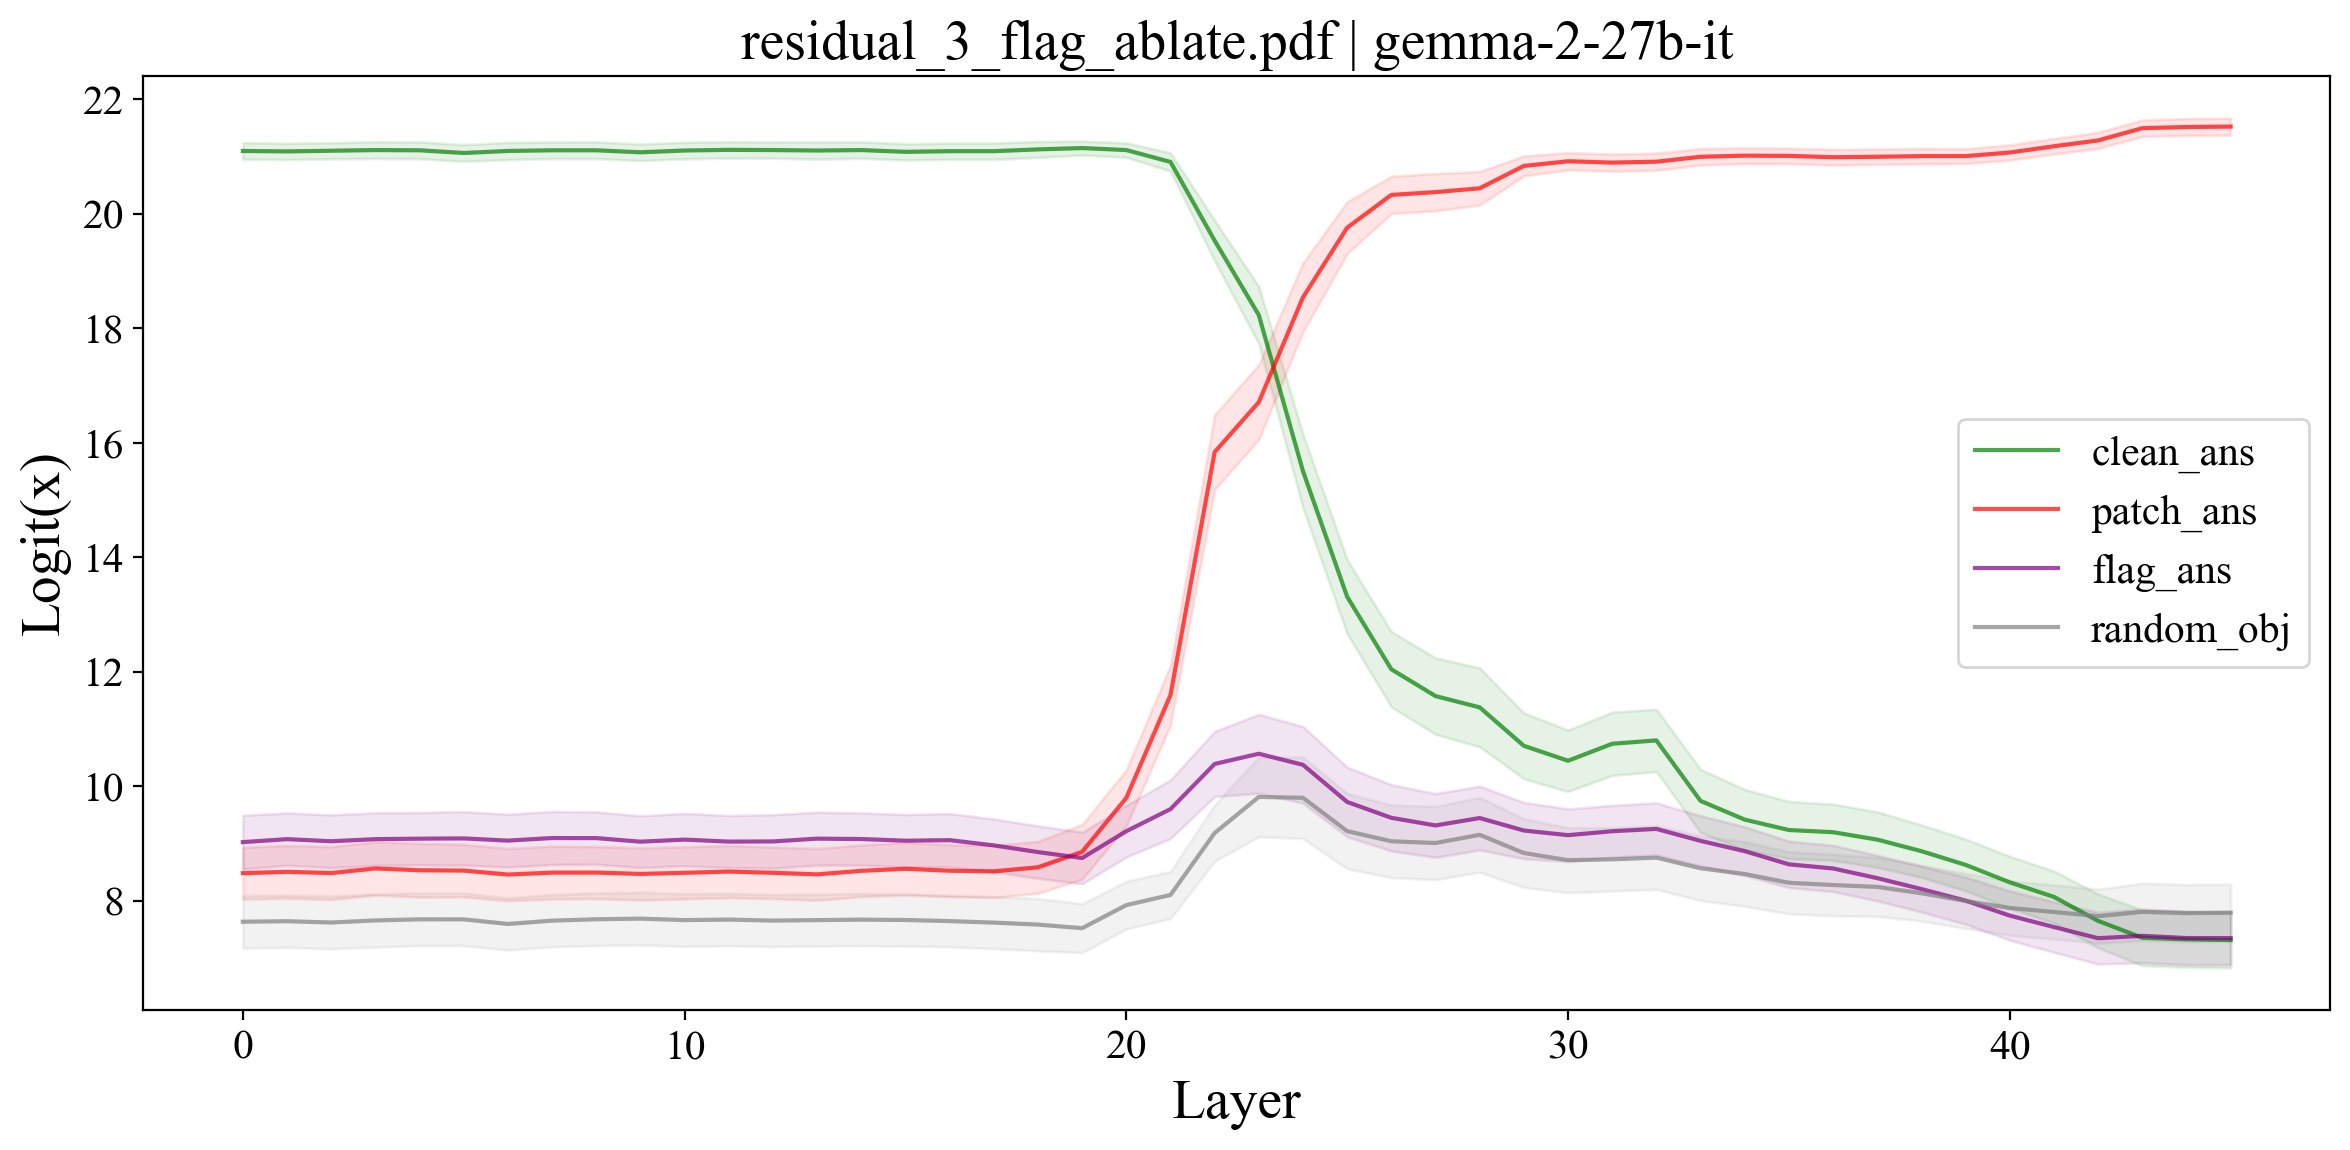

In [49]:
import numpy as np
from matplotlib import pyplot as plt

colors = {
    "clean_ans": "green",
    "patch_ans": "red",
    "flag_ans": "purple",
    "random_obj": "gray",
}

plt.figure(figsize=(12, 6))
for token_type, layerwise_scores_list in scores.items():
    # Compute mean and std deviation across results for each layer
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )

    plt.plot(
        mean_scores,
        label=f"{token_type}",
        alpha=0.7,
        color=colors.get(token_type, None),
    )
    plt.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors.get(token_type, None),
    )

file_name = f"residual_{prompt_template_idx}"
if ablate_ans_flag:
    file_name += "_flag_ablate"
file_name += ".pdf"

save_dir = os.path.join("figures", model_key.split("/")[-1], "residual")
os.makedirs(save_dir, exist_ok=True)

plt.xlabel("Layer")
plt.ylabel("Logit(x)")
plt.title(f"{file_name} | {mt.name.split('/')[-1]}")
# plt.title(f"Residual + Ablate Flag | {mt.name.split('/')[-1]}")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, file_name), bbox_inches="tight")